# Narrowband Energy Detection from Wideband Signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy import signal
import seaborn as sns
sns.set()

In [2]:
# Signal Generator Parameters:
freq = 3000.0 # Hz
duration = 10.0 # seconds
oversamp = 10 # oversampling rate
Fs = freq*oversamp # samples per second
AWGN_SNR = 0.0 # dB

NOTE: **Additive White Gaussian Noise (AWGN)** is sampled from a normal distribution with ${\mu} = 0$ and ${\sigma}^2 = 10^\frac{-SNR}{10}$ ([ref](https://www.sharetechnote.com/html/Handbook_Communication_awgn.html))

In [3]:
def sig_gen(freq, duration, Fs, AWGN_SNR=None, complex=True):
    '''
    Synthesizes a sinusoidal signal (with optional noise)
    
    freq = sinusoid frequency (in Hz)
    duration = duration of synthesized signal (in seconds)
    Fs = sample frequency (in samples per second)
    AWGN_SNR = signal-to-noise ratio for gaussian noise (in dB)
    complex = return complex samples? (boolean)
    '''
    if freq is None: # no tone present, just noise
        sig = 0.0
        freq = 0.0
    else:
        sig = 1.0
        
    omega = 2*np.pi*freq
    t = np.linspace(0,duration, int(duration*Fs))
    
    if AWGN_SNR is not None:
        # Additive White Gaussian Noise
        # Create gaussian white noise signal:
        awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
        if complex:
            awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs)) + \
                   1j*np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
            return sig*np.exp(-1j*(omega*t)) + awgn
        else:
            awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
            return sig*np.real(np.exp(-1j*(omega*t))) + awgn

In [4]:
def psd_plot(signal, NFFT=1024, width=16, freq_range=None, Fs=None):
    if NFFT%2 != 0:
        NFFT = NFFT+1
    i=0
    if len(signal)%NFFT != 0:
        signal = signal[:-(len(signal)%NFFT)] # discard extra data that can't be used
    output = np.zeros(int(len(signal)))
    while i < len(signal):
        output[i:i+NFFT] = np.absolute(np.fft.fft(signal[i:i+NFFT]))
        i += NFFT
    fft_data = output.reshape((int(np.floor(len(output)/NFFT)), NFFT))
    # square the values:
    squared = np.square(fft_data)
    # normalize by highest value in each fft, compute in dB:
    normalized_db = 10*np.log10(squared/np.amax(squared))
    # plot:
    if fft_data.shape[0]*16//300 == 0.0:
        assert False, "Not enough data to plot! Try inputting a longer signal."
    fig, ax = plt.subplots(figsize=(width, fft_data.shape[0]*16//300))
    ax.grid(False)
    ax.matshow(np.flip(normalized_db[:,int(NFFT/2):], axis=1))
    
    #to compute the frequencies the value of the samples per second is needed (Fs)
    if freq_range != None:
        # TODO: scale ticks on x-axis according to appropriate frequencies
        x_ax_current = range(0, int(NFFT/2), 1)
        x_ax_scale = Fs/NFFT
        x_ticks_freq = ticker.FuncFormatter(lambda x_ax_current, pos: '{0:g}'.format(round(x_ax_current*x_ax_scale)))            
        ax.xaxis.set_major_formatter(x_ticks_freq)
        ax.set(xlabel='Frequency (Hz)')
        #altered ticks such that there are more reference points
        ax.set_xticks(list(range(0, int(NFFT/2), 32))) 
        
        if len(freq_range) == 1:
            end_freq = freq_range[0]
        else:
            start_freq = freq_range[0]
            end_freq = freq_range[-1]
        
    if Fs != None:
        # TODO: scale ticks on y-axis according to time in seconds
        y_ax_current = range(0, int(Fs))
        y_ax_scale = 30
        y_ticks_freq = ticker.FuncFormatter(lambda y_ax_current, pos: '{0:g}'.format(round(y_ax_current/y_ax_scale)))
        ax.yaxis.set_major_formatter(y_ticks_freq)
        ax.set(ylabel='Time (s)')
        #ax.set_yticks(list(range(0, int(Fs/y_ax_scale),100))) 
       
    return fig, ax

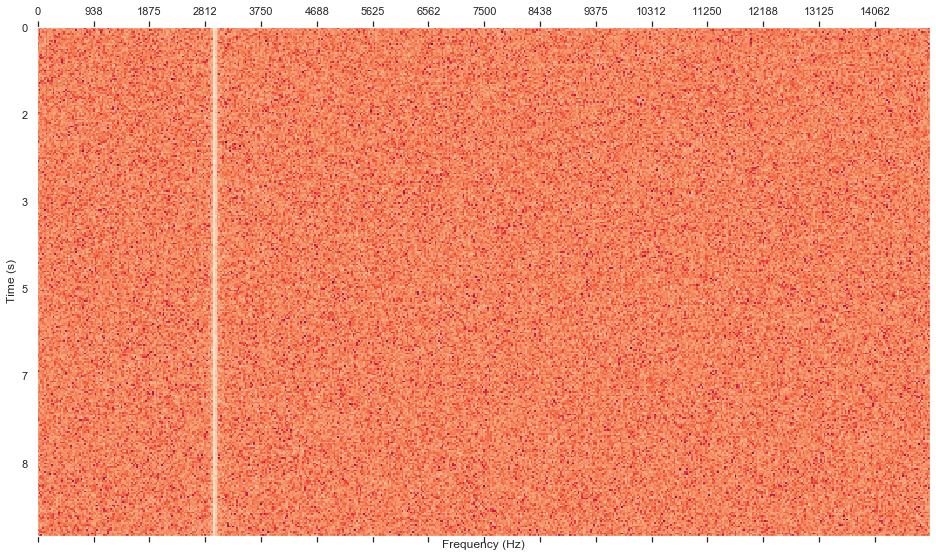

In [5]:
my_signal = sig_gen(freq, duration, Fs, AWGN_SNR=-10.0, complex=True)
temp = psd_plot(my_signal, freq_range=[10], Fs=Fs)

In [6]:
# Create and on-off-keying (OOK) signal:
freq = 3000.0
Fs = 10*freq
AWGN_SNR = 0.0

noise_duration = 0.5
burst_duration = 0.25

my_signal2 = np.concatenate([sig_gen(None, 3*noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, 3*noise_duration, Fs, AWGN_SNR)])

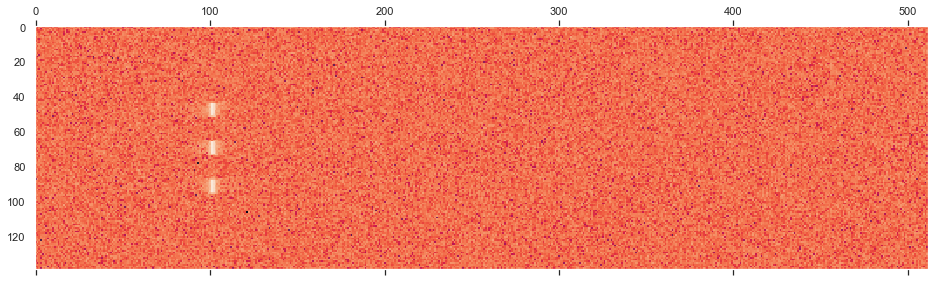

In [7]:
temp = psd_plot(my_signal2)

In [8]:
def compare_threshold(window, threshold, freq_range = None):
    '''
    returns a list of NB energy detections within the given signal window, based on the threshold given
    
    '''
    # Computes FFT of the given signal window
    window_fft = np.fft.fft(window, len(window))
    window_fft_normalized = (2/len(window)) * np.abs(window_fft)
    window_freq_fft = np.fft.fftfreq(len(window_fft))

    # Determines which (if any) FFT coefficients' magnitude exceeds threshold
    threshold = np.average(window_fft_normalized) * 4
    values_exceeding_thresh = window_fft_normalized > threshold
    bins_exceeding_threshold = abs(window_freq_fft[values_exceeding_thresh])
    
    # Returns a list of FFT bins exceeding energy threshold within a certian freq range
    return bins_exceeding_threshold, threshold
    

In [9]:
def run_energy_detection(signal, window_size=1024):
    '''
    runs energy detection routine on the wideband signal given
    '''
    bins_up = []
    Fs = 30000
    i, k = 0, 0
    freq_range = [2000, 4000]
    threshold = 0
    # Window size can be addjusted as an argument
    
    # loops through each window, returning the time it was up and at what frequency
    if len(signal)%window_size != 0:
        signal = signal[:-(len(signal)%window_size)] # discard extra data that can't be used
        
    while i < len(signal):
        bins_exceeding, current_threshold = compare_threshold(signal[i:i+window_size], threshold, freq_range)
        
        for val in range(0,len(bins_exceeding)):
            bins_up.append((k,round(bins_exceeding[val]*Fs)))
        
        threshold = current_threshold
        k += 1
        i += window_size

    # returns list of tuples that contain up/down times at certain frequency
    return bins_up
    
    

In [10]:
signal1_test = run_energy_detection(my_signal)

In [11]:
signal1_test

[(0, 2988.0),
 (1, 3018.0),
 (1, 2988.0),
 (2, 3018.0),
 (2, 2988.0),
 (3, 2988.0),
 (4, 2988.0),
 (5, 2988.0),
 (6, 3018.0),
 (6, 2988.0),
 (7, 3018.0),
 (7, 2988.0),
 (8, 2988.0),
 (9, 2988.0),
 (10, 2988.0),
 (11, 3018.0),
 (11, 2988.0),
 (12, 2988.0),
 (13, 2988.0),
 (14, 3018.0),
 (14, 2988.0),
 (15, 2988.0),
 (16, 3018.0),
 (16, 2988.0),
 (17, 2988.0),
 (18, 2988.0),
 (19, 3018.0),
 (19, 2988.0),
 (20, 3018.0),
 (20, 2988.0),
 (21, 2988.0),
 (22, 3018.0),
 (22, 2988.0),
 (23, 3018.0),
 (23, 2988.0),
 (24, 2988.0),
 (25, 3018.0),
 (25, 2988.0),
 (26, 2988.0),
 (27, 3018.0),
 (27, 2988.0),
 (28, 2988.0),
 (29, 3018.0),
 (29, 2988.0),
 (30, 2988.0),
 (31, 3018.0),
 (31, 2988.0),
 (32, 2988.0),
 (33, 3018.0),
 (33, 2988.0),
 (34, 3018.0),
 (34, 2988.0),
 (35, 3018.0),
 (35, 2988.0),
 (36, 3018.0),
 (36, 2988.0),
 (37, 3018.0),
 (37, 2988.0),
 (38, 3018.0),
 (38, 2988.0),
 (39, 3018.0),
 (39, 2988.0),
 (40, 3018.0),
 (40, 2988.0),
 (42, 3018.0),
 (42, 2988.0),
 (43, 3018.0),
 (43, 298

In [12]:
signal2_test = run_energy_detection(my_signal2)

In [13]:
signal2_test

[(44, 3047.0),
 (44, 3018.0),
 (44, 2988.0),
 (44, 2959.0),
 (45, 3047.0),
 (45, 3018.0),
 (45, 2988.0),
 (45, 2959.0),
 (45, 2930.0),
 (46, 3047.0),
 (46, 3018.0),
 (46, 2988.0),
 (46, 2959.0),
 (47, 3047.0),
 (47, 3018.0),
 (47, 2988.0),
 (47, 2959.0),
 (48, 3018.0),
 (48, 2988.0),
 (48, 2959.0),
 (49, 3018.0),
 (49, 2988.0),
 (49, 2959.0),
 (50, 3018.0),
 (50, 2988.0),
 (50, 2959.0),
 (51, 3047.0),
 (51, 3018.0),
 (51, 2988.0),
 (51, 2959.0),
 (66, 3018.0),
 (66, 2988.0),
 (66, 2959.0),
 (67, 3047.0),
 (67, 3018.0),
 (67, 2988.0),
 (67, 2959.0),
 (68, 3047.0),
 (68, 3018.0),
 (68, 2988.0),
 (68, 2959.0),
 (69, 3047.0),
 (69, 3018.0),
 (69, 2988.0),
 (69, 2959.0),
 (69, 2930.0),
 (70, 3047.0),
 (70, 3018.0),
 (70, 2988.0),
 (70, 2959.0),
 (71, 3047.0),
 (71, 3018.0),
 (71, 2988.0),
 (71, 2959.0),
 (72, 3047.0),
 (72, 3018.0),
 (72, 2988.0),
 (72, 2959.0),
 (73, 3047.0),
 (73, 3018.0),
 (73, 2988.0),
 (73, 2959.0),
 (87, 3018.0),
 (87, 2988.0),
 (88, 3047.0),
 (88, 3018.0),
 (88, 2988